In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
en = np.fromfile("tests/en.bin", dtype=np.int32, count=-1)
mag = np.fromfile("tests/mag.bin", dtype=np.float64, count=-1)
spec_heat = np.fromfile("tests/spec_heat.bin", dtype=np.float64, count=-1)
#susc = np.fromfile("susc.bin", dtype=np.float64, count=-1)
#temp = np.fromfile("temp.bin", dtype=np.float64, count=-1)
#data = np.fromfile("ising.bin", dtype=np.int8, count=-1)
#idx_history = np.fromfile("idx_history.bin", dtype=np.float64, count=-1).astype(np.int32)

FileNotFoundError: [Errno 2] No such file or directory: 'tests/spec_heat.bin'

NameError: name 'en' is not defined

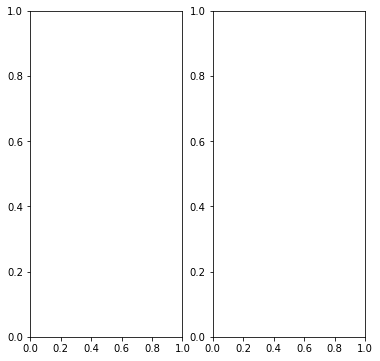

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6));
ax[0].plot(en);
ax[1].plot(mag);

ax[0].set_title("Energy");
ax[1].set_title("Magnetization");

In [6]:
N = 100
data = np.fromfile("ising.bin", dtype=np.int8, count=-1).reshape((N, N))
fig, ax = plt.subplots(1, 1, figsize=(8, 8));
X, Y = np.meshgrid(range(N), range(N))
ax.axis('off')
ax.pcolormesh(X, Y, data, cmap=plt.cm.RdBu);
ax.set_title('Time=%d'%0);

FileNotFoundError: [Errno 2] No such file or directory: 'ising.bin'

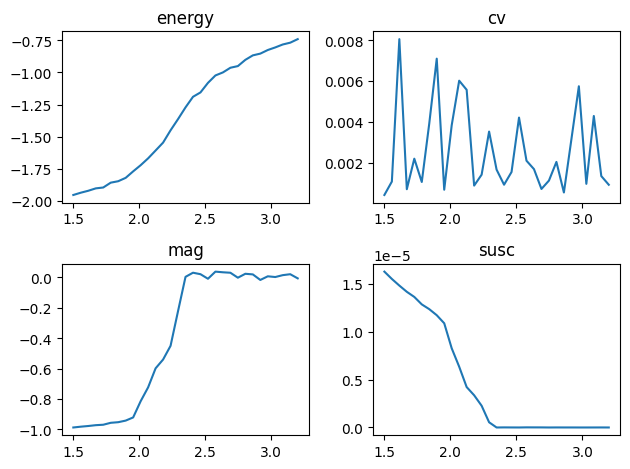

In [12]:
cv = np.fromfile("tests/cv.bin", dtype=np.float64, count=-1)
en = np.fromfile("tests/en.bin", dtype=np.float64, count=-1)
mag = np.fromfile("tests/mag.bin", dtype=np.float64, count=-1)
susc = np.fromfile("tests/susc.bin", dtype=np.float64, count=-1)
T = np.fromfile("tests/T.bin", dtype=np.float64, count=-1)

fig, ax = plt.subplots(2, 2);
ax[0, 0].plot(T, en);
ax[0, 0].set_title("energy");
ax[0, 1].plot(T, cv);
ax[0, 1].set_title("cv");
ax[1, 0].plot(T, mag);
ax[1, 0].set_title("mag");
ax[1, 1].plot(T, susc);
ax[1, 1].set_title("susc");

fig.tight_layout();

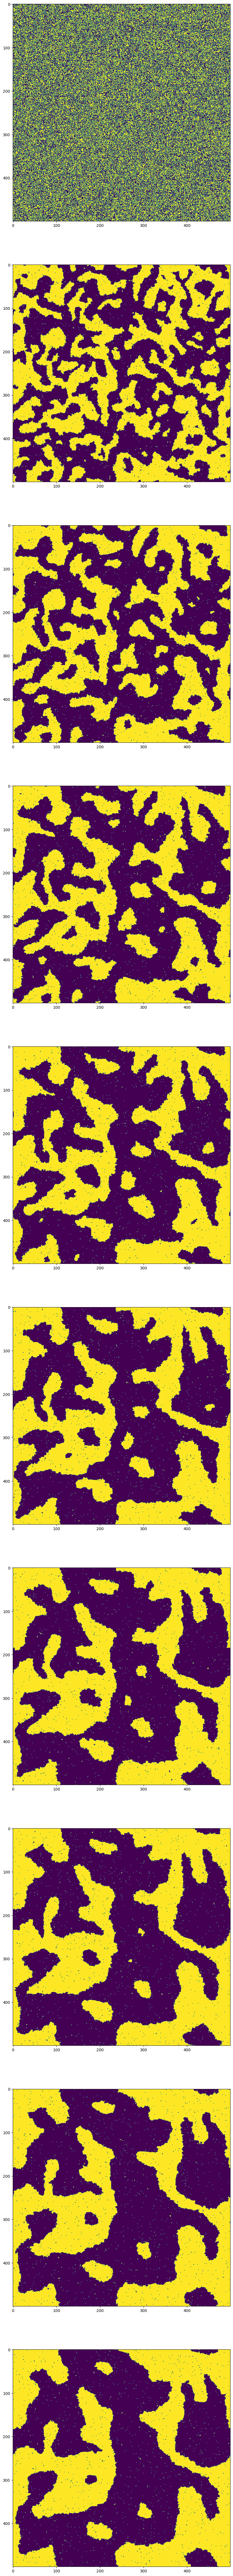

In [20]:
n = 500
fig, ax = plt.subplots(10, figsize=(12, 12 * 10));
for i in range(10):
	lattice = np.fromfile("tests/lattice" + str(i), dtype=np.int8, count=-1).reshape((n, n));
	ax[i].imshow(lattice);

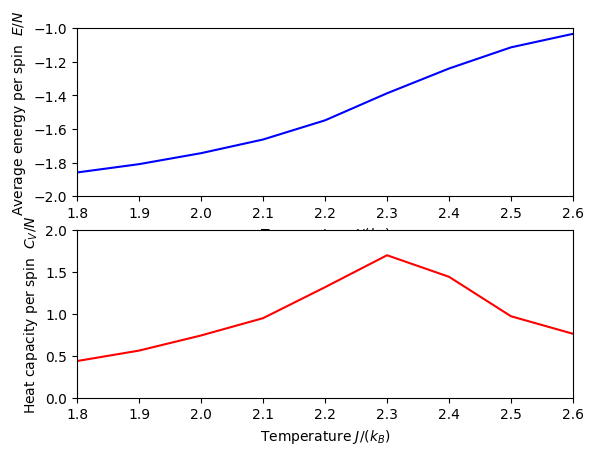

In [73]:
import numpy, sys, math
from  matplotlib import pyplot as plt
import numpy as np


def periodic (i, limit, add):
    """
    Choose correct matrix index with periodic
    boundary conditions

    Input:
    - i:     Base index
    - limit: Highest \"legal\" index
    - add:   Number to add or subtract from i
    """
    return (i+limit+add) % limit

def monteCarlo(temp, size, trials):
    """
    Calculate the energy and magnetization
    (\"straight\" and squared) for a given temperature

    Input:
    - temp:   Temperature to calculate for
    - size:   dimension of square matrix
    - trials: Monte-carlo trials (how many times do we
                                  flip the matrix?)

    Output:
    - E_av:       Energy of matrix averaged over trials, normalized to spins**2
    - E_variance: Variance of energy, same normalization * temp**2
    """

    #Setup spin matrix, initialize to ground state
    spin_matrix = numpy.zeros( (size,size), numpy.int8) + 1

    #Create and initialize variables
    E = 0
    E_av = E2_av = 0
    
    #Setup array for possible energy changes
    w = numpy.zeros(17,numpy.float64)
    for de in range(-8,9,4): #include +8
        w[de+8] = math.exp(-de/temp)
    
    #Calculate initial energy
    for j in range(size): 
        for i in range(size):
            E -= spin_matrix.item(i,j)*\
                 (spin_matrix.item(periodic(i,size,-1),j) + spin_matrix.item(i,periodic(j,size,1)))

    #Start metropolis MonteCarlo computation 
    for i in range(trials):
        #Metropolis
        #Loop over all spins, pick a random spin each time
        for s in range(size**2):
            x = int(numpy.random.random()*size)
            y = int(numpy.random.random()*size)
            deltaE = 2*spin_matrix.item(x,y)*\
                     (spin_matrix.item(periodic(x,size,-1), y) +\
                      spin_matrix.item(periodic(x,size,1),  y) +\
                      spin_matrix.item(x, periodic(y,size,-1)) +\
                      spin_matrix.item(x, periodic(y,size,1)))
            if numpy.random.random() <= w[deltaE+8]:
                #Accept!
                spin_matrix[x,y] *= -1
                E += deltaE
            
        #Update expectation values
        E_av    += E
        E2_av   += E**2

    E_av       /= float(trials);
    E2_av      /= float(trials);
    #Calculate variance and normalize to per-point and temp
    E_variance  = (E2_av-E_av*E_av)/float(size*size*temp*temp);
    #Normalize returned averages to per-point
    E_av       /= float(size*size);

    return (E_av, E_variance)
    
    
# Main program

# values of the lattice, number of Monte Carlo cycles and temperature domain
size        =   20
trials      =   100000
temp_init   = 1.8
temp_end    = 2.6
temp_step   = 0.1


temps = numpy.arange(temp_init,temp_end+temp_step/2,temp_step,float)
Dim = np.size(temps)
energy = np.zeros(Dim)
heatcapacity = np.zeros(Dim) 
temperature = np.zeros(Dim)
for i, temp in enumerate(temps):
    (E_av, E_variance) = monteCarlo(temp,size,trials)
    temperature[i] = temp
    energy[i] = E_av
    heatcapacity[i] = E_variance
plt.figure(1)
plt.subplot(211)
plt.axis([1.8,2.6,-2.0, -1.0])
plt.xlabel(r'Temperature $J/(k_B)$')
plt.ylabel(r'Average energy per spin  $E/N$')
plt.plot(temperature, energy, 'b-')
plt.subplot(212)
plt.axis([1.8,2.6, 0.0, 2.0])
plt.plot(temperature, heatcapacity, 'r-')
plt.xlabel(r'Temperature $J/(k_B)$')
plt.ylabel(r'Heat capacity per spin  $C_V/N$')
plt.savefig('energycv.pdf')
plt.show()